# Mnist Handwritten Digit dataset with Pytorch (CNN)
> Hi Everyone, in this notebook we're going to train a neural network for the famous MNIST digit dataset, using Pytorch
Just a friendly reminder that the MNIST Handwritten digit dataset has 70,000 images of size 28 * 28

References: This [notebook](https://www.kaggle.com/tarunpaparaju/mnist-competition-pytorch-nn) from [Tarun Paparaju](https://www.kaggle.com/tarunpaparaju)


In [1]:
# Bread and butter of Machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing torch libraries
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader

# Bread and butter of Machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To make waiting look fancy
from tqdm import tqdm

# Meeting the data

In [2]:
train = pd.read_csv('.\\input\\train.csv')
test = pd.read_csv('.\\input\\test.csv')
train.head(), test.head()

(   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0         0   
 
    pixel780  pixel781  pixel782  pixel783  
 0         0   

> All the above data looks like garbage to us. We'll need to convert them to images.

In [3]:
# train.shape[0] is the number of images in the training data, and test.shape[0] holds the number of images in the test data
train.shape[0], test.shape[0]

(42000, 28000)

# Converting the data in csv files to images
> Let's convert our data from pixel values in csv to actual images

Pytorch has it's own thing to handle data feeding to the neural network. We'll need to create a class and put in methods for data retrieval. I highly recommend using help(Dataset) to get some insight about what it can do. Will hardly take 2 minutes of your time. Do it.

In [4]:
def to_tensor(data):
    return [torch.FloatTensor(point) for point in data]

class MNISTData(Dataset):
    def __init__(self, df, X_col, Y_col=None):
        """
        We're divding the values by 255 to normalize the dataset. 
        It speeds up training. Why 255? because that's the maximum value for a pixel
        """
        self.features = df[X_col].values/255
        self.features = self.features.reshape(len(self.features), 1, 28, 28)
        self.targets = df[Y_col].values.reshape((-1, 1)) 
        # -1 indicates that the first dimension could be anything
        
    """
    To return the length of the dataset
    """
    def __len__(self):
        return len(self.targets)
    
    """
    This method will get data from the dataframe, based on the index values(idx)
    """
    def __getitem__(self, idx):
        return to_tensor([self.features[idx], self.targets[idx]])
        
        

In [5]:
# We'll split our data into 90% training and 10% test data 
split = int(0.9 * len(train))
valid_data = train[split:].reset_index(drop=True)
train_data = train[:split].reset_index(drop=True)
valid_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


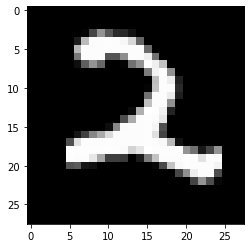

In [6]:
# Getting features of the image (pixel 0-783, 784 pixels in total for a 28*28 image)
X_col = list(train.columns[1:])
y_col = "label"

train_set = MNISTData(train_data, X_col, y_col)
valid_set = MNISTData(valid_data, X_col, y_col)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True)

for data in train_loader:
    X_train, y_train = data
    fig = plt.figure()
    plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
    break

# Making a Dummy Neural Network
> So we're gonna define a model with 2 convolutional layers and 2 Fully Connected layers. The thing with pytorch is, we gotta know the dimensions of our data, at the end of our convolutional layers, to be able to connect them to the fully connected layers. So we're just gonna define a dummy model with our convolutional layers,and check the dimensions of the last convolutional layer. Once we know that, we'll define our original model with all the dimensions in place 

In [7]:
class dummyModel(nn.Module):
    def __init__(self):
        super(dummyModel, self).__init__()
        
        """
        In layer 1, which is a convolutional layer, input channels will be 1, 
        since our data consists of graycale images.
        
        out_channels is the number of filters, of size 3(kernel_size). 
        out_channels can be whatever we want, so I'm gonna select 4.
        
        stride is the number of steps that a filter jumps, from it's previous position.
        
        padding is the number of pixels added to both sides of the input data(image), for each dimension.
        Padding mode is the value of the padding pixels.
        """
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        
        #Layer 3
        # FC layer
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
        
        

# Training our (Dummy) Convolutional Neural Network

In [8]:
network = dummyModel()
print(network)
num_epochs = 5
for epoch in range(num_epochs):
    for train_batch in train_loader:
        train_X, train_y = train_batch
        # train_X = train_X.reshape(len(train_X), 1, 28, 28)
        outputs = network.forward(train_X)
        # To check dimensions of our tensor
        op = outputs.flatten(start_dim=1, end_dim=-1)
        break
print(outputs.shape)
print(op.shape)
        
        
        

dummyModel(
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
)
torch.Size([64, 8, 7, 7])
torch.Size([64, 392])


Our Tensor is in the shape  $(N, C, H, W)$,  where
  * $N$ = batch size
  * $C$ = Number of channels
  * $H$ = Height of the image
  * $W$ = Width of the image
  
![](http://)Hence, we flatten it to $(N, F)$, where
* $N$ = batch size
* $F=C*H*W$

> So we need 392 neurons in the first FC layer after our convolutional layers? Noted.
How did we get 392? simple, $8*7*7$

# Creating our Model for training
> Playtime is over, let's get down to business

In [9]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(4))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(8))

        self.fc1 = nn.Sequential(
            nn.Linear(392, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(128))

        self.fc2 = nn.Sequential(
            nn.Linear(128, 10))
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        # print(f"After conv1, dimensions are: {x.shape}")
        x = self.conv2(x)
        # print(f"After conv2, dimensions are: {x.shape}")
        # Flattening the image
        x = x.flatten(start_dim=1, end_dim=-1)
        x = self.fc1(x)
        # print(f"After fc1, dimensions are: {x.shape}")
        x = self.fc2(x)
        x = nn.LogSoftmax(dim=1)(x)
        # print(f"After fc2, dimensions are: {x.shape}")
        return x

# Training our Neural Network

In [10]:
# Before we start training our neural network, we'll define our accuracy function
def acc(y_true, y_pred):
    y_true = y_true.long().squeeze()
    y_pred = torch.argmax(y_pred, axis=1)
    return (y_true==y_pred).float().sum()/len(y_true)

In [11]:
network = model()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters())
loss = []
accuracy = []
num_epochs = 2
for i in range(1, num_epochs+1):
    for data in train_loader:
        batch_X, batch_Y = data
        batch_prediction = network.forward(batch_X)
        #print(batch_prediction[0])
        
        batch_Y = batch_Y.long().squeeze()
        #print(f"Y_Pred Dimensions: {batch_Y.shape}\tPrediction Dimensions:{batch_prediction.shape}")
        batch_loss = criterion(batch_prediction, batch_Y)
        batch_acc = acc(batch_Y, batch_prediction)
    
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        loss.append(batch_loss)
        accuracy.append(batch_acc)
    with torch.no_grad():
        for valid_batch in valid_loader:
            valid_X, valid_Y = valid_batch
            valid_Y = valid_Y.long().squeeze()
            valid_prediction = network.forward(valid_X)
            valid_loss = criterion(valid_prediction, valid_Y)
            valid_acc = acc(valid_Y, valid_prediction)
    print("----------------------------------------------------------------------------------------------")  
    print(f"Yo, this is epoch number {i}")
    print(f"Training Accuracy: {batch_acc:.4f}\tTraining Loss:{batch_loss:.4f}\nValidation Accuracy: {valid_acc:.4f}\tValidation Loss: {valid_loss:.4f}")

----------------------------------------------------------------------------------------------
Yo, this is epoch number 1
Training Accuracy: 0.9750	Training Loss:0.0983
Validation Accuracy: 0.9250	Validation Loss: 0.2492
----------------------------------------------------------------------------------------------
Yo, this is epoch number 2
Training Accuracy: 0.9500	Training Loss:0.0960
Validation Accuracy: 1.0000	Validation Loss: 0.0316


# Let's make Predictions

In [12]:
# Gotta prepare the test set first
test[y_col] = [-1]*len(test)

test_set = MNISTData(test, X_col, y_col)
test_loader = tqdm(DataLoader(test_set, batch_size=1024, shuffle=False))
test_pred = []
with torch.no_grad():
    for test_X, _ in test_loader:
        pred = network.forward(test_X)
        test_pred.extend(np.argmax(pred, axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.57it/s]


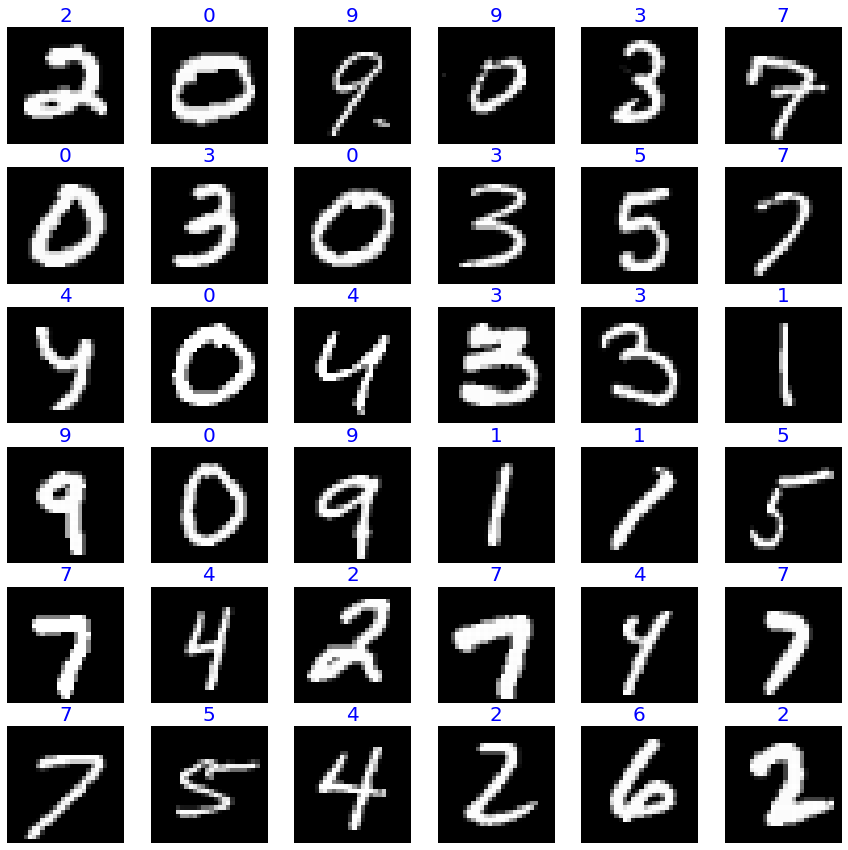

In [13]:
test_X, _ = next(iter(test_loader))
test_X = test_X[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    image = image.reshape(28, 28)
    ax[i//6][i%6].axis('off')
    ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(test_pred[i].item(), fontsize=20, color='blue')

In [14]:
submissions = pd.read_csv('.\\input\\sample_submission.csv')
labels = [x.item() for x in test_pred]
submissions["Label"] = labels
submissions.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [15]:
submissions.to_csv("submission.csv", index=False)

In [ ]:
# Source: https://www.kaggle.com/code/techpy/mnist-with-pytorch-cnn